# Quickstart Example with Synthetic Bandit Data
---
This notebook provides an example of conducting OPE of several different evaluation policies with synthetic bandit feedback data.

Our example with synthetic bandit data contains the follwoing four major steps:
- (1) Synthetic Data Generation
- (2) Off-Policy Learning
- (3) Off-Policy Evaluation
- (4) Evaluation of OPE Estimators

Please see [../examples/synthetic](../synthetic) for a more sophisticated example of the evaluation of OPE with synthetic bandit data.

In [1]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor as RandomForest
from sklearn.linear_model import Ridge
# import open bandit pipeline (obp)
import obp
from obp.dataset import (
    SyntheticContinuousBanditDataset,
    linear_reward_funcion_continuous,
    quadratic_reward_funcion_continuous,
    pricing_reward_funcion_continuous,
    linear_behavior_policy_funcion_continuous,
)
from obp.policy import NNPolicyLearnerForContinuousAction
from obp.ope import (
    OffPolicyEvaluationForContinuousAction, 
    RegressionModelForContinuousAction,
    KernelizedInverseProbabilityWeighting as KernelizedIPW,
    KernelizedSelfNormalizedInverseProbabilityWeighting as KernelizedSNIPW,
    KernelizedDoublyRobust as KernelizedDR,
)

In [2]:
# obp version
print(obp.__version__)

0.4.0


## (1) Synthetic Data Generation
We prepare easy-to-use synthetic data generator: `SyntheticBanditDataset` class in the dataset module.

It takes number of actions (`n_actions`), dimension of context vectors (`dim_context`), reward function (`reward_function`), and behavior policy (`behavior_policy_function`) as inputs and generates a synthetic bandit dataset that can be used to evaluate the performance of decision making policies (obtained by `off-policy learning`) and OPE estimators.

In [4]:
# generate a synthetic bandit dataset with 10 actions
# we use `logistic function` as the reward function and `linear_behavior_policy` as the behavior policy.
# one can define their own reward function and behavior policy such as nonlinear ones. 
dataset = SyntheticContinuousBanditDataset(
    dim_context=5,
    reward_function=linear_reward_funcion_continuous,
    behavior_policy_function=linear_behavior_policy_funcion_continuous,
    random_state=12345,
)
# obtain training and test sets of synthetic logged bandit feedback
n_rounds_train, n_rounds_test = 10000, 100000
bandit_feedback_train = dataset.obtain_batch_bandit_feedback(
    n_rounds=n_rounds_train, reward_noise=10, action_noise=10, min_action=0, max_action=50,
)
bandit_feedback_test = dataset.obtain_batch_bandit_feedback(
    n_rounds=n_rounds_train, reward_noise=10, action_noise=10, min_action=0, max_action=50,
)

# `bandit_feedback` is a dictionary storing synthetic logged bandit feedback
bandit_feedback_train

{'n_rounds': 10000,
 'context': array([[-0.20470766,  0.47894334, -0.51943872, -0.5557303 ,  1.96578057],
        [ 1.39340583,  0.09290788,  0.28174615,  0.76902257,  1.24643474],
        [ 1.00718936, -1.29622111,  0.27499163,  0.22891288,  1.35291684],
        ...,
        [-1.27028221,  0.80914602, -0.45084222,  0.47179511,  1.89401115],
        [-0.68890924,  0.08857502, -0.56359347, -0.41135069,  0.65157486],
        [ 0.51204121,  0.65384817, -1.98849253, -2.14429131, -0.34186901]]),
 'action_by_behavior_policy': array([22.09589494,  4.82590159,  2.79160918, ...,  0.38251442,
         4.05082169, 13.2826414 ]),
 'reward': array([ 8.59330148, 21.65355856,  9.2726068 , ...,  4.4167942 ,
         2.9585803 , 12.43422192]),
 'pscore': array([0.01450048, 0.06458638, 0.06649492, ..., 0.0503255 , 0.0643714 ,
        0.03761972]),
 'expected_reward': array([16.3599131 ,  3.71466597,  1.87333446, ...,  4.4246705 ,
         2.66587781, 11.21774205])}

## (2) Off-Policy Learning
After generating synthetic data, we now train some candidate evaluation policies using the training bandit dataset. <br>

We use *IPW Learner* implemented in the policy module to train evaluation policies. 
We also use *RandomForestClassifier* and *LogisticRegression* implemented in scikit-learn for base machine learning methods.

In [5]:
dpg_nn_policy_learner = NNPolicyLearnerForContinuousAction(
    dim_context=bandit_feedback_train["context"].shape[1],
    pg_method="dpg",
    output_space=(0,50),
    hidden_layer_size=(100,10),
    activation="relu",
    solver="adam",
    early_stopping=True,
    random_state=12345,
    q_func_estimator_hyperparams=dict(
        hidden_layer_size=(10,10),
        max_iter=10,
    )
)

dpg_nn_policy_learner.fit(
    context=bandit_feedback_train["context"],
    action_by_behavior_policy=bandit_feedback_train["action_by_behavior_policy"],
    reward=bandit_feedback_train["reward"],
    pscore=bandit_feedback_train["pscore"],
)

action_by_dpg_nn_policy = dpg_nn_policy_learner.predict(
    context=bandit_feedback_test["context"]
)

policy learning: 100%|██████████| 200/200 [00:28<00:00,  7.02it/s]


In [36]:
ipw_nn_policy_learner = NNPolicyLearnerForContinuousAction(
    dim_context=bandit_feedback_train["context"].shape[1],
    pg_method="ipw",
    bandwidth=0.1,
    output_space=(0,50),
    hidden_layer_size=(100,10),
    activation="relu",
    solver="adam",
    early_stopping=True,
    random_state=12345,
)

ipw_nn_policy_learner.fit(
    context=bandit_feedback_train["context"],
    action_by_behavior_policy=bandit_feedback_train["action_by_behavior_policy"],
    reward=bandit_feedback_train["reward"],
    pscore=bandit_feedback_train["pscore"],
)

action_by_ipw_nn_policy = ipw_nn_policy_learner.predict(
    context=bandit_feedback_test["context"]
)

policy learning: 100%|██████████| 200/200 [04:09<00:00,  1.25s/it]


In [37]:
dr_d_nn_policy_learner = NNPolicyLearnerForContinuousAction(
    dim_context=bandit_feedback_train["context"].shape[1],
    pg_method="dr-d",
    bandwidth=0.1,
    hidden_layer_size=(100,10),
    activation="relu",
    solver="adam",
    early_stopping=True,
    random_state=12345,
)

dr_d_nn_policy_learner.fit(
    context=bandit_feedback_train["context"],
    action_by_behavior_policy=bandit_feedback_train["action_by_behavior_policy"],
    reward=bandit_feedback_train["reward"],
    pscore=bandit_feedback_train["pscore"],
)

action_by_dr_d_nn_policy = dr_d_nn_policy_learner.predict(
    context=bandit_feedback_test["context"]
)

policy learning: 100%|██████████| 200/200 [04:34<00:00,  1.37s/it]


In [38]:
dr_k_nn_policy_learner = NNPolicyLearnerForContinuousAction(
    dim_context=bandit_feedback_train["context"].shape[1],
    pg_method="dr-k",
    bandwidth=0.1,
    hidden_layer_size=(100,10),
    activation="relu",
    solver="adam",
    early_stopping=True,
    random_state=12345,
)

dr_k_nn_policy_learner.fit(
    context=bandit_feedback_train["context"],
    action_by_behavior_policy=bandit_feedback_train["action_by_behavior_policy"],
    reward=bandit_feedback_train["reward"],
    pscore=bandit_feedback_train["pscore"],
)

action_by_dr_k_nn_policy = dr_k_nn_policy_learner.predict(
    context=bandit_feedback_test["context"]
)

policy learning: 100%|██████████| 200/200 [09:49<00:00,  2.95s/it]


## (3) Off-Policy Evaluation (OPE)
Our next step is OPE which attempts to estimate the performance of evaluation policies using the logged bandit feedback and OPE estimators.

Here, we use the **InverseProbabilityWeighting (IPW)**, **DirectMethod (DM)**, and **Doubly Robust (DR)** estimators and visualize the OPE results.

In [8]:
# estimate the mean reward function by using ML model (Logistic Regression here)
# the estimated rewards are used by model-dependent estimators such as DM and DR
regression_model = RegressionModelForContinuousAction(
    base_model=Ridge(random_state=12345),
)
# please refer to https://arxiv.org/abs/2002.08536 about the details of the cross-fitting procedure.
estimated_rewards_by_reg_model = regression_model.fit_predict(
    context=bandit_feedback_test["context"],
    action_by_behavior_policy=bandit_feedback_test["action_by_behavior_policy"],
    reward=bandit_feedback_test["reward"],
    n_folds=3, # use 3-fold cross-fitting
    random_state=12345,
)

In [9]:
# estimate the policy value of the evaluation policies based on their action choice probabilities
# it is possible to set multiple OPE estimators to the `ope_estimators` argument
ope = OffPolicyEvaluationForContinuousAction(
    bandit_feedback=bandit_feedback_test,
    ope_estimators=[
        KernelizedIPW(kernel="gaussian", bandwidth=0.1), 
        KernelizedSNIPW(kernel="gaussian", bandwidth=0.1), 
        KernelizedDR(kernel="gaussian", bandwidth=0.1),
    ]
)

/Users/usaito/.pyenv/versions/3.8.2/lib/python3.8/site-packages/obp-0.4.0-py3.8.egg/obp/ope/estimators_continuous.py:419: RuntimeWarning: invalid value encountered in true_divide
  estimated_rewards /= (kernel_func(u) / pscore).sum() / reward.shape[0]
                      mean  95.0% CI (lower)  95.0% CI (upper)
kernelized_ipw    0.000000          0.000000          0.000000
kernelized_snipw       NaN               NaN               NaN
kernelized_dr     5.522356          5.495603          5.549224 

/Users/usaito/.pyenv/versions/3.8.2/lib/python3.8/site-packages/obp-0.4.0-py3.8.egg/obp/ope/estimators_continuous.py:419: RuntimeWarning: invalid value encountered in true_divide
  estimated_rewards /= (kernel_func(u) / pscore).sum() / reward.shape[0]


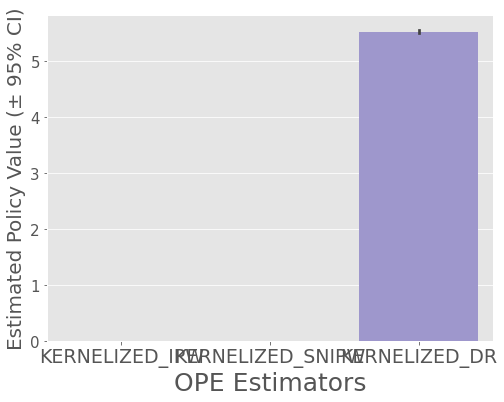

In [10]:
# estimate the policy value of IPWLearner with Logistic Regression
estimated_policy_value_a, estimated_interval_a = ope.summarize_off_policy_estimates(
    action_by_evaluation_policy=action_by_nn_policy,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model
)
print(estimated_interval_a, '\n')
# visualize estimated policy values of IPWLearner with Logistic Regression by the three OPE estimators
# and their 95% confidence intervals (estimated by nonparametric bootstrap method)
ope.visualize_off_policy_estimates(
    action_by_evaluation_policy=action_by_nn_policy,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    n_bootstrap_samples=10000, # number of resampling performed in the bootstrap procedure
    random_state=12345,
)

                      mean  95.0% CI (lower)  95.0% CI (upper)
kernelized_ipw    2.958762          2.312631          3.661285
kernelized_snipw  4.588734          3.554246          5.663140
kernelized_dr     9.138808          8.266355         10.174812 



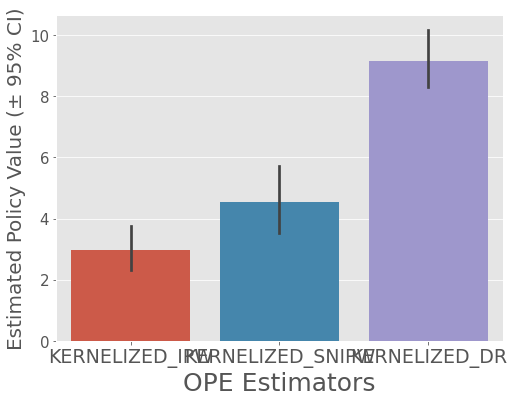

In [11]:
# estimate the policy value of IPWLearner with Logistic Regression
estimated_policy_value_a, estimated_interval_a = ope.summarize_off_policy_estimates(
    action_by_evaluation_policy=action_by_linear_policy,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model
)
print(estimated_interval_a, '\n')
# visualize estimated policy values of IPWLearner with Logistic Regression by the three OPE estimators
# and their 95% confidence intervals (estimated by nonparametric bootstrap method)
ope.visualize_off_policy_estimates(
    action_by_evaluation_policy=action_by_linear_policy,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    n_bootstrap_samples=10000, # number of resampling performed in the bootstrap procedure
    random_state=12345,
)

                      mean  95.0% CI (lower)  95.0% CI (upper)
kernelized_ipw    2.968274          2.216709          4.190213
kernelized_snipw  1.938037          1.445794          2.544863
kernelized_dr     8.822132          7.685999         10.302887 



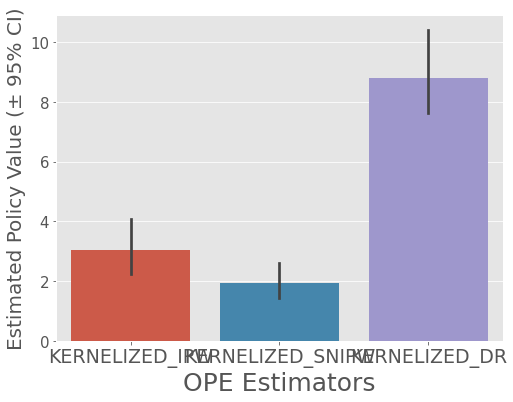

In [12]:
# estimate the policy value of IPWLearner with Random Forest by OPE estimators
estimated_policy_value_b, estimated_interval_b = ope.summarize_off_policy_estimates(
    action_by_evaluation_policy=action_by_threshold_policy,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model
)
print(estimated_interval_b, '\n')
# visualize estimated policy values of IPWLearner with Random Forest by the three OPE estimators
# and their 95% confidence intervals (estimated by nonparametric bootstrap method)
ope.visualize_off_policy_estimates(
    action_by_evaluation_policy=action_by_threshold_policy,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    n_bootstrap_samples=10000, # number of resampling performed in the bootstrap procedure
    random_state=12345,
)

                      mean  95.0% CI (lower)  95.0% CI (upper)
kernelized_ipw    2.429039          2.105352          2.780512
kernelized_snipw  3.946706          3.377334          4.692901
kernelized_dr     8.435596          8.073875          8.884427 



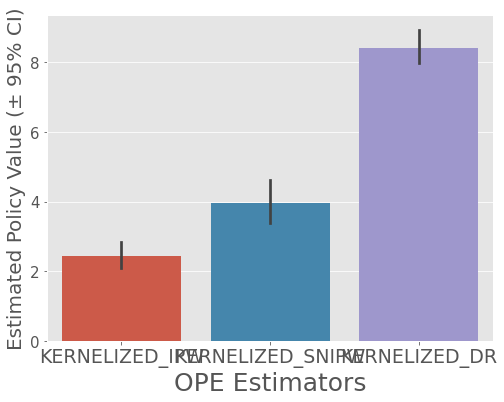

In [13]:
# estimate the policy value of Uniform Random
estimated_policy_value_c, estimated_interval_c = ope.summarize_off_policy_estimates(
    action_by_evaluation_policy=action_by_sin_policy,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model
)
print(estimated_interval_c, '\n')
# visualize estimated policy values of Uniform Random by the three OPE estimators
# and their 95% confidence intervals (estimated by nonparametric bootstrap method)
ope.visualize_off_policy_estimates(
    action_by_evaluation_policy=action_by_sin_policy,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    n_bootstrap_samples=10000, # number of resampling performed in the bootstrap procedure
    random_state=12345,
)

Our OPE procedure estimates that IPWLearners largely outperform the Uniform Random policy.

Moreover, IPWLearner with Logistic Regression seems to be the best one.

## (4) Evaluation of OPE estimators
Our final step is **the evaluation of OPE**, which evaluates and compares the estimation accuracy of OPE estimators.

With synthetic data, we can calculate the policy value of the evaluation policies. 
Therefore, we can compare the policy values estimated by OPE estimators with the ground-turths to evaluate the accuracy of OPE.

In [39]:
# we first calculate the policy values of the three evaluation policies using the expected rewards of the test data
policy_names = ["DPG", "IPW", "DR-D", "DR-K"]
action_by_evaluation_policy_list = [
    action_by_dpg_nn_policy,
    action_by_ipw_nn_policy,
    action_by_dr_d_nn_policy,
    action_by_dr_k_nn_policy,
]
for name, action_ in zip(policy_names, action_by_evaluation_policy_list):
    true_policy_value = dataset.calc_ground_truth_policy_value(
        context=bandit_feedback_test["context"],
        action=action_
    )
    print(f'policy value of {name}: {true_policy_value}')

policy value of DPG: 44.16536619601103
policy value of IPW: 2.347098337046625
policy value of DR-D: 420525.53628436645
policy value of DR-K: 2.378688044789735


In fact, IPWLearner with Logistic Regression reveals the best performance among the three evaluation policies.

Using the above policy values, we evaluate the estimation accuracy of the OPE estimators.

In [16]:
# evaluate the estimation performances of OPE estimators 
# by comparing the estimated policy values of IPWLearner with Logistic Regression and its ground-truth.
# `summarize_estimators_comparison` returns a pandas dataframe containing estimation performances of given estimators 
relative_ee_for_ipw_lr = ope.summarize_estimators_comparison(
    ground_truth_policy_value=dataset.calc_ground_truth_policy_value(
        expected_reward=bandit_feedback_test["expected_reward"],
        action_dist=action_dist_ipw_lr,
    ),
    action_dist=action_dist_ipw_lr,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    metric="relative-ee", # "relative-ee" (relative estimation error) or "se" (squared error)
)

# estimation performances of the three estimators (lower means accurate)
relative_ee_for_ipw_lr

NameError: name 'action_dist_ipw_lr' is not defined

In [ ]:
# evaluate the estimation performance of OPE estimators 
# by comparing the estimated policy values of IPWLearner with Random Forest and its ground-truth.
# `summarize_estimators_comparison` returns a pandas dataframe containing estimation performances of given estimators 
relative_ee_for_ipw_rf = ope.summarize_estimators_comparison(
    ground_truth_policy_value=dataset.calc_ground_truth_policy_value(
        expected_reward=bandit_feedback_test["expected_reward"],
        action_dist=action_dist_ipw_rf,
    ),
    action_dist=action_dist_ipw_rf,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    metric="relative-ee", # "relative-ee" (relative estimation error) or "se" (squared error)
)

# estimation performances of the three estimators (lower means accurate)
relative_ee_for_ipw_rf

In [ ]:
# evaluate the estimation performance of OPE estimators 
# by comparing the estimated policy values of Uniform Random and its ground-truth.
# `summarize_estimators_comparison` returns a pandas dataframe containing estimation performances of given estimators 
relative_ee_for_random = ope.summarize_estimators_comparison(
    ground_truth_policy_value=dataset.calc_ground_truth_policy_value(
        expected_reward=bandit_feedback_test["expected_reward"],
        action_dist=action_dist_random,
    ),
    action_dist=action_dist_random,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    metric="relative-ee", # "relative-ee" (relative estimation error) or "se" (squared error)
)

# estimation performances of the three estimators (lower means accurate)
relative_ee_for_random

Please see [../examples/synthetic](../synthetic) for a more sophisticated example of the evaluation of OPE with synthetic bandit data.